# Import libraries and csv

In [68]:
!pip install gdown==4.6.0
!pip install -q pytorch-lightning


In [69]:
!gdown 1onocuCd4eJOXGzgcFqF6mkBWYu_To_R5
!gdown 1zDO0WB11NE3ugusS-u5zxZZaWwR-2p5o
!gdown 1aG7kZJ_b_mKAV3oqn5r0fQKTc1VEwkLu
!gdown 1ry_oMoG-Dz8zA5BaZ2rfOIhVuGm5Whpa
!gdown 1TR8OrGSjoyckFY7hU-f2teaBmnd9Sjb3

Downloading...
From: https://drive.google.com/uc?id=1onocuCd4eJOXGzgcFqF6mkBWYu_To_R5
To: /content/data_synth_train.csv
100% 21.0M/21.0M [00:00<00:00, 45.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zDO0WB11NE3ugusS-u5zxZZaWwR-2p5o
To: /content/data_synth_test.csv
100% 3.81M/3.81M [00:00<00:00, 62.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1aG7kZJ_b_mKAV3oqn5r0fQKTc1VEwkLu
To: /content/data_submission_example.csv
100% 7.60k/7.60k [00:00<00:00, 5.84MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ry_oMoG-Dz8zA5BaZ2rfOIhVuGm5Whpa
To: /content/df_train_first_processing.csv
100% 28.7M/28.7M [00:00<00:00, 84.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1TR8OrGSjoyckFY7hU-f2teaBmnd9Sjb3
To: /content/clean_data.csv
100% 48.2M/48.2M [00:00<00:00, 121MB/s]


In [70]:
#import libraries here
import os
import copy
import math
import gc
import random
import numpy as np
import pandas as pd

import torch

import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import Trainer

import matplotlib.pyplot as plt
import seaborn as sns

from typing import List, Tuple, Any, Dict, Union, Set, Callable

# from transformers import AutoTokenizer, AutoModel, AlbertTokenizer, AlbertModel

import json

from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
# Usa lo stesso DataFrame 'df' e le stesse 'colonne_da_scalare'




In [71]:
#CONST

# features = ['timestamp_in_seconds', 'temperature', 'humidity', 'CO2CosIRValue', 'CO2MG811Value', 'MOX1', 'MOX2', 'MOX3', 'MOX4',  'COValue']
features = ['timestamp_in_seconds', 'var_temperature', 'var_humidity', 'var_CO2CosIRValue', 'var_CO2MG811Value', 'var_MOX1', 'varMOX2', 'var_MOX3', 'var_MOX4',  'var_COValue']
labels_col = ['Living room', 'Bedroom', 'Bathroom', 'Kitchen', 'Hallway']

scaler = MinMaxScaler()

SEED:int = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
pl.seed_everything(SEED)

INFO:lightning_fabric.utilities.seed:Seed set to 1234


1234

# Download dataset

In [72]:
df_sub = pd.read_csv('/content/data_submission_example.csv')
df_test = pd.read_csv('/content/data_synth_test.csv')
# df_train = pd.read_csv('/content/data_synth_train.csv')
# df_train = pd.read_csv('/content/df_train_first_processing.csv')
df_train = pd.read_csv('/content/clean_data.csv')

In [73]:
df_train

df_original = df_train.copy()

# df_train = df_train[~((df_train['timestamp_in_seconds'] >=0) * (df_train['timestamp_in_seconds'] <= 6*3600) +
#           (df_train['timestamp_in_seconds'] >= 23*3600) * (df_train['timestamp_in_seconds'] <= 24*3600))]

# df_train = df_train[~((df_train['Bedroom'] == 0)*(df_train['Living room'] == 0)*(df_train['Bathroom'] == 0)*(df_train['Kitchen'] == 0)*(df_train['Hallway'] == 0))]

In [74]:
df_train

,Unnamed: 0,Living room,Bedroom,Bathroom,Kitchen,Hallway,timestamp_in_seconds,var_CO2CosIRValue,var_CO2MG811Value,var_MOX1,varMOX2,var_MOX3,var_MOX4,var_COValue,var_temperature,var_humidity,mapped_date
0,0,0,0,0,0,0,7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
1,1,0,0,0,0,0,27,-0.018349,0.003766,0.010225,0.002837,-0.001517,0.005000,0.000000,-0.003293,0.005023,1
2,2,1,0,0,0,0,47,0.000000,-0.005629,-0.006073,0.001414,-0.003040,-0.011609,-0.008197,-0.003775,-0.008616,1
3,3,1,0,0,0,0,67,-0.009346,0.003774,-0.004073,0.002825,0.000000,0.001678,0.041322,0.000474,0.007127,1
4,4,1,0,0,0,0,87,-0.028302,0.000000,0.002045,-0.007042,0.003049,0.000000,0.031746,-0.002841,0.004142,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265682,304563,0,0,0,0,0,13903,0.000000,0.001890,0.004556,-0.002882,0.001538,0.001718,0.000000,0.001817,0.003636,72
265683,304564,0,0,0,0,0,13923,0.019608,-0.001887,0.000000,0.002890,0.000000,0.000000,0.000000,-0.005442,-0.001268,72
265684,304565,0,0,0,0,0,13943,-0.028846,0.000000,0.004535,0.000000,0.000000,0.001715,0.009259,0.007296,-0.000181,72
265685,304566,0,0,0,0,0,13963,0.000000,0.000000,-0.004515,0.000000,0.000000,0.001712,-0.009174,-0.002263,0.001814,72


In [75]:
# df_train = df_train.drop(0, axis=0)
df_train.head()

,Unnamed: 0,Living room,Bedroom,Bathroom,Kitchen,Hallway,timestamp_in_seconds,var_CO2CosIRValue,var_CO2MG811Value,var_MOX1,varMOX2,var_MOX3,var_MOX4,var_COValue,var_temperature,var_humidity,mapped_date
0,0,0,0,0,0,0,7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
1,1,0,0,0,0,0,27,-0.018349,0.003766,0.010225,0.002837,-0.001517,0.005000,0.000000,-0.003293,0.005023,1
2,2,1,0,0,0,0,47,0.000000,-0.005629,-0.006073,0.001414,-0.003040,-0.011609,-0.008197,-0.003775,-0.008616,1
3,3,1,0,0,0,0,67,-0.009346,0.003774,-0.004073,0.002825,0.000000,0.001678,0.041322,0.000474,0.007127,1
4,4,1,0,0,0,0,87,-0.028302,0.000000,0.002045,-0.007042,0.003049,0.000000,0.031746,-0.002841,0.004142,1


# Dataset statistics

In [ ]:
'Living room', 'Bedroom', 'Bathroom', 'Kitchen', 'Hallway'

('Living room', 'Bedroom', 'Bathroom', 'Kitchen', 'Hallway')

In [ ]:
df_living = df_train[df_train['Living room'] == 1]
df_bedroom = df_train[df_train['Bedroom'] == 1]
df_bathroom = df_train[df_train['Bathroom'] == 1]
df_kitchen = df_train[df_train['Kitchen'] == 1]
df_hallway = df_train[df_train['Hallway'] == 1]

In [ ]:
df_living[['temperature', 'humidity', 'CO2CosIRValue', 'CO2MG811Value', 'MOX1', 'MOX2', 'MOX3', 'MOX4',  'COValue']].describe()

KeyError: "None of [Index(['temperature', 'humidity', 'CO2CosIRValue', 'CO2MG811Value', 'MOX1',\n       'MOX2', 'MOX3', 'MOX4', 'COValue'],\n      dtype='object')] are in the [columns]"

In [ ]:
df_bedroom[['temperature', 'humidity', 'CO2CosIRValue', 'CO2MG811Value', 'MOX1', 'MOX2', 'MOX3', 'MOX4',  'COValue']].describe()


KeyError: "None of [Index(['temperature', 'humidity', 'CO2CosIRValue', 'CO2MG811Value', 'MOX1',\n       'MOX2', 'MOX3', 'MOX4', 'COValue'],\n      dtype='object')] are in the [columns]"

In [ ]:
df_bathroom[['temperature', 'humidity', 'CO2CosIRValue', 'CO2MG811Value', 'MOX1', 'MOX2', 'MOX3', 'MOX4',  'COValue']].describe()

,temperature,humidity,CO2CosIRValue,CO2MG811Value,MOX1,MOX2,MOX3,MOX4,COValue
count,35232.000000,35232.000000,35232.000000,35232.000000,35232.000000,35232.000000,35232.000000,35232.000000,35232.000000
mean,21.213265,52.845063,124.421463,520.936024,475.440537,686.498552,644.034173,570.955722,127.112852
std,2.131712,5.084628,48.827819,31.888112,43.532697,40.333910,43.809027,50.545762,37.253895
min,14.450000,39.570000,41.000000,469.000000,308.000000,563.000000,511.000000,415.000000,72.000000
25%,19.850000,48.870000,96.000000,500.000000,449.000000,664.000000,620.000000,543.000000,100.000000
50%,21.130000,52.100000,107.000000,507.000000,477.000000,691.000000,648.000000,575.000000,117.000000
75%,22.920000,55.780000,130.000000,528.000000,500.000000,714.000000,673.000000,605.000000,145.000000
max,26.500000,65.490000,289.000000,628.000000,608.000000,788.000000,755.000000,702.000000,280.000000


In [ ]:
# Impostazioni opzionali per migliorare l'aspetto dei grafici
sns.set(style="whitegrid")

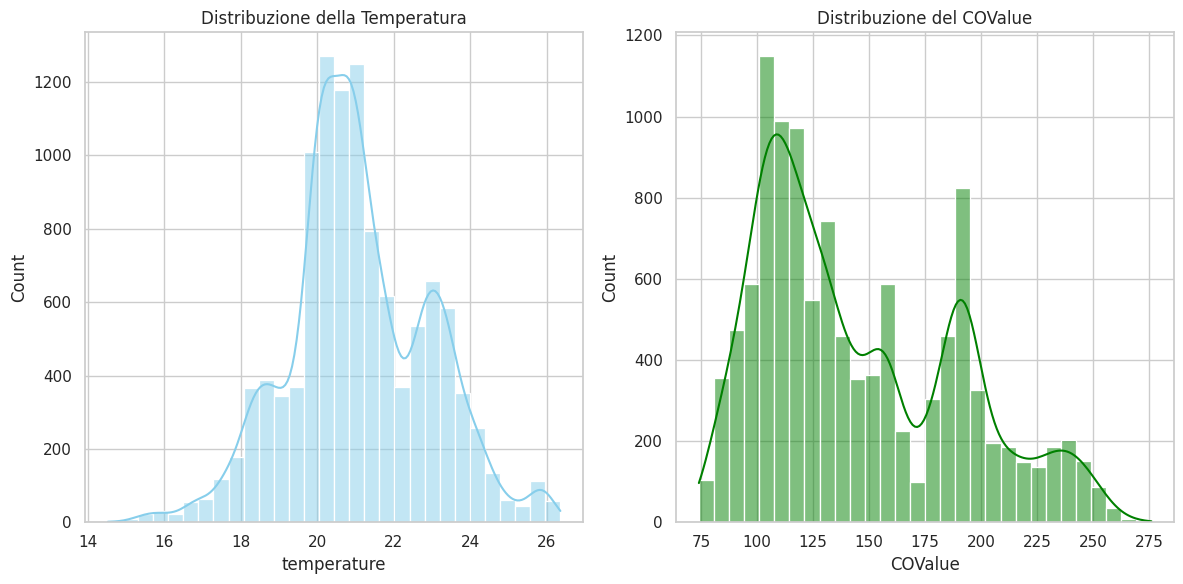

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_living['temperature'], bins=30, kde=True, color='skyblue')
plt.title('Distribuzione della Temperatura')

plt.subplot(1, 2, 2)
sns.histplot(df_living['COValue'], bins=30, kde=True, color='green')
plt.title('Distribuzione del COValue')

plt.tight_layout()
plt.show()

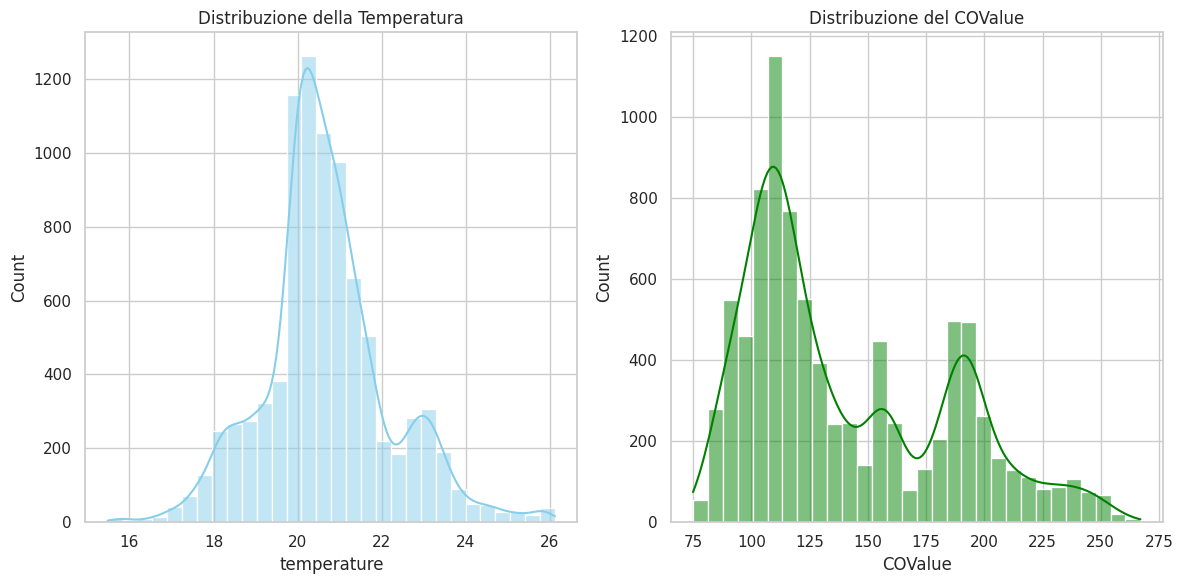

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_bedroom['temperature'], bins=30, kde=True, color='skyblue')
plt.title('Distribuzione della Temperatura')

plt.subplot(1, 2, 2)
sns.histplot(df_bedroom['COValue'], bins=30, kde=True, color='green')
plt.title('Distribuzione del COValue')

plt.tight_layout()
plt.show()

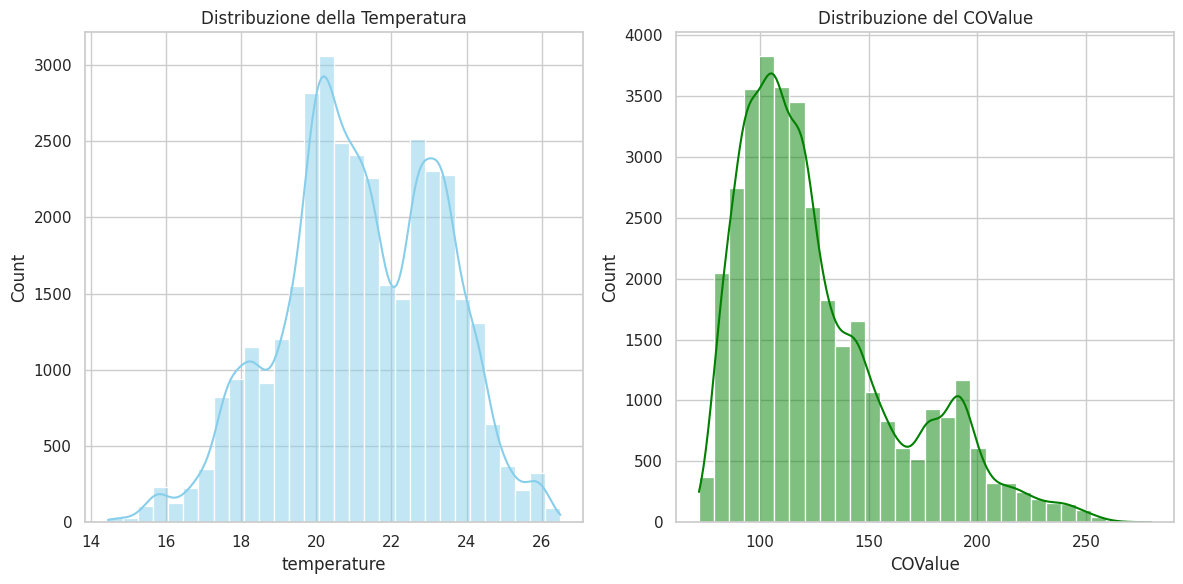

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_bathroom['temperature'], bins=30, kde=True, color='skyblue')
plt.title('Distribuzione della Temperatura')

plt.subplot(1, 2, 2)
sns.histplot(df_bathroom['COValue'], bins=30, kde=True, color='green')
plt.title('Distribuzione del COValue')

plt.tight_layout()
plt.show()

# Preprocessing

## Labels preparation

In [76]:
# df_train.head()
# df_train['MOX4'].describe()

# #Generate the inputs and labels for each row example
# df_labels = df_train[['Living room', 'Bedroom', 'Bathroom', 'Kitchen', 'Hallway']]

# labels = []
# for index, row in df_train.iterrows():
#       # print(row.values.tolist())
#       row_input = row[['temperature', 'humidity', 'CO2CosIRValue', 'CO2MG811Value', 'MOX1', 'MOX2', 'MOX3', 'MOX4',  'COValue']].values.tolist()
#       row_labels = row[['Living room', 'Bedroom', 'Bathroom', 'Kitchen', 'Hallway']].values.tolist()
#       print(row_input)
#       print(row_labels)
#       # lab = row.values.tolist()
#       # labels.append(lab)
#       break

In [77]:
df_trial_lstm = df_train.copy()

In [78]:
df_trial_lstm[['timestamp_in_seconds']] = df_trial_lstm[['timestamp_in_seconds']] / df_trial_lstm[['timestamp_in_seconds']].max()
# df_original[['timestamp_in_seconds']] = df_original[['timestamp_in_seconds']] / df_original[['timestamp_in_seconds']].max()

In [79]:
# df_trial_lstm = df_trial_lstm.astype('float64')

In [80]:
# Applica lo scaler alle colonne selezionate
# df_trial_lstm[features] = scaler.fit_transform(df_trial_lstm[features])


In [81]:
# df_trial_lstm  = df_trial_lstm.reset_index(drop=True)

df_trial_lstm


,Unnamed: 0,Living room,Bedroom,Bathroom,Kitchen,Hallway,timestamp_in_seconds,var_CO2CosIRValue,var_CO2MG811Value,var_MOX1,varMOX2,var_MOX3,var_MOX4,var_COValue,var_temperature,var_humidity,mapped_date
0,0,0,0,0,0,0,0.000081,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
1,1,0,0,0,0,0,0.000313,-0.018349,0.003766,0.010225,0.002837,-0.001517,0.005000,0.000000,-0.003293,0.005023,1
2,2,1,0,0,0,0,0.000544,0.000000,-0.005629,-0.006073,0.001414,-0.003040,-0.011609,-0.008197,-0.003775,-0.008616,1
3,3,1,0,0,0,0,0.000775,-0.009346,0.003774,-0.004073,0.002825,0.000000,0.001678,0.041322,0.000474,0.007127,1
4,4,1,0,0,0,0,0.001007,-0.028302,0.000000,0.002045,-0.007042,0.003049,0.000000,0.031746,-0.002841,0.004142,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265682,304563,0,0,0,0,0,0.160916,0.000000,0.001890,0.004556,-0.002882,0.001538,0.001718,0.000000,0.001817,0.003636,72
265683,304564,0,0,0,0,0,0.161148,0.019608,-0.001887,0.000000,0.002890,0.000000,0.000000,0.000000,-0.005442,-0.001268,72
265684,304565,0,0,0,0,0,0.161379,-0.028846,0.000000,0.004535,0.000000,0.000000,0.001715,0.009259,0.007296,-0.000181,72
265685,304566,0,0,0,0,0,0.161611,0.000000,0.000000,-0.004515,0.000000,0.000000,0.001712,-0.009174,-0.002263,0.001814,72


In [82]:
# import numpy as np

# def create_sequences(df, n_steps):
#     X, y = [], []
#     for i in tqdm(range(1, len(df)-1), total = len(df)):
#         end_ix = i + n_steps - 1
#         if end_ix > len(df)-1:
#             break
#         # raccogli input e output
#         seq_x, seq_y = df.loc[i:end_ix, features].values.tolist(), df.loc[i:end_ix, labels_col].values.tolist()
#         # print(seq_x)
#         # print(seq_y)
#         X.append(seq_x)
#         y.append(seq_y)
#     return torch.tensor(np.array(X)), torch.tensor(np.array(y))

# # Numero di timesteps per sequenza
# n_steps = 20

# # Crea sequenze
# X, y = create_sequences(df_train.iloc[:100000], n_steps)


In [83]:
def create_sequences(df, n_steps):
    X, y = [], []
    # for i in tqdm(range(1,len(df) - 20)):
    for i in tqdm(range(100000 - n_steps)):
        seq_y = [a for a in df_original.loc[i:i+n_steps-1, labels_col].values.tolist()]
        right_y = df_original.loc[i+n_steps, labels_col].values.tolist()

        X.append(seq_y)
        y.append(right_y)

    return X, y

# Numero di timesteps per sequenza
n_steps = 20

# Crea sequenze
X, y = create_sequences(df_trial_lstm, n_steps)


100%|██████████| 99980/99980 [03:40<00:00, 453.19it/s]


In [84]:
X = torch.tensor(X)
y = torch.tensor(y)

In [85]:
print(X.shape)
print(y.shape)

torch.Size([99980, 20, 5])
torch.Size([99980, 5])


In [86]:
# def create_sequences(df, n_steps):
#     X, y = [], []
#     # for i in tqdm(range(1,len(df) - 20)):
#     for i in tqdm(range(10000)):
#         # end_ix = i + n_steps - 1
#         start_ix = i - n_steps + 1

#         if start_ix < 1:
#           continue


#         # raccogli input e output
#         seq_x, seq_y = df_original.loc[start_ix:i, features].values.tolist(), df_original.loc[i, labels_col].values.tolist()
#         # seq_x, seq_y = df_original.loc[i:end_ix, features].values, df.loc[end_ix, labels_col].values
#         # seq_x, seq_y = df.loc[i:end_ix, features].values, df.loc[end_ix, labels_col].values
#         # print(seq_y)
#         seq_x = torch.tensor(seq_x)
#         seq_y = torch.tensor(seq_y)

#         X.append(seq_x)
#         y.append(seq_y)

#     # print(X.shape)
#     # print(y.shape)
#     return torch.stack(X), torch.stack(y)

# # Numero di timesteps per sequenza
# n_steps = 20

# # Crea sequenze
# X, y = create_sequences(df_trial_lstm.iloc[0:50000], n_steps)


In [87]:
# def create_sequences(df):
#     X, y = [], []
#     for i in tqdm(range(1,len(df))):
#         seq_x, seq_y = df_original.loc[i, features].values, df_original.loc[i, labels_col].values
#         # print(seq_x)
#         # print(seq_y)
#         seq_x = torch.tensor(seq_x)
#         seq_y = torch.tensor(seq_y)

#         X.append(seq_x)
#         y.append(seq_y)

#     # print(X.shape)
#     # print(y.shape)
#     return torch.stack(X), torch.stack(y)

# # Numero di timesteps per sequenza
# n_steps = 20

# # Crea sequenze
# X, y = create_sequences(df_train.iloc[:10000])


In [88]:
print(X.shape)
print(y.shape)

torch.Size([99980, 20, 5])
torch.Size([99980, 5])


In [89]:
train_index = int(X.shape[0] * 0.8)

In [90]:
train_index

79984

In [91]:
# # Divisione in set di addestramento e test
X_train, X_val, y_train, y_val = X[0:train_index], X[train_index:], y[0:train_index], y[train_index:]
X_train, X_val, y_train, y_val = X[0:train_index], X[train_index:], y[0:train_index], y[train_index:]


In [92]:
print(X_train.shape)
print(X_val.shape)

torch.Size([79984, 20, 5])
torch.Size([19996, 20, 5])


In [93]:
# # Divisione in set di addestramento e test
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)


# Hyperparameters

In [94]:
#hyperparameters
class hypers:
    save_model = False
    save_model_path = ''

    load_model = True
    load_model_path = ''

    input_size = 5
    hidden_size = 64
    num_layers = 2
    num_classes = 5

    dropout_rate = 0.2

    learning_rate = 1e-3

    epochs = 50
    batch_size = 64
    print_step = 100
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset

In [95]:
class HomeDataset(Dataset):
  def __init__(self,
               X, Y):
    self.X = X
    self.Y = Y

  def __len__(self):
    return len(self.X)


  def __getitem__(self,index):
    x = self.X[index]
    y = self.Y[index]

    return x, y

# Models

## Baseline

In [96]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiLabelNN(nn.Module):
    def __init__(self, hypers):
        super(MultiLabelNN, self).__init__()

        self.lstm = nn.LSTM(input_size=hypers.input_size,
                            hidden_size=hypers.hidden_size,
                            num_layers=hypers.num_layers,
                            dropout=hypers.dropout_rate,
                            batch_first=True,
                            bidirectional = False)

        self.fc1 = nn.Linear(hypers.hidden_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.classifier = nn.Linear(32, hypers.num_classes)

        self.dropout = torch.nn.Dropout(hypers.dropout_rate)
        self.relu = nn.ReLU()


    def forward(self, x, h0, c0):

        output, (hn, cn) = self.lstm(x, (h0, c0)) #batch x 20 x 10
        output = output[:,-1,:]

        output = self.dropout(self.relu(self.fc1(output)))
        output = self.dropout(self.relu(self.fc2(output)))

        logits = self.classifier(output)
        logits = torch.sigmoid(logits)

        rets = {
            'logits': logits,
            'hidden': (h0, c0)
        }
        return rets

## Other models

In [97]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LSTMNN(nn.Module):
    def __init__(self, hypers):
        super(LSTMNN, self).__init__()

        self.lstm = nn.LSTM(input_size=hypers.input_size,
                            hidden_size=hypers.hidden_size,
                            num_layers=hypers.num_layers,
                            dropout=hypers.dropout_rate,
                            batch_first=True,
                            bidirectional = False)

        self.fc1 = nn.Linear(hypers.input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.classifier = nn.Linear(64, hypers.num_classes)

        self.dropout = torch.nn.Dropout(hypers.dropout_rate)
        self.relu = nn.ReLU()


    def forward(self, x):
        output, _ = self.lstm(x) #batch x 20 x 10
        # output = self.dropout(self.relu(self.fc1(output)))
        # output = self.dropout(self.relu(self.fc2(output)))
        logits = self.classifier(output)
        logits = torch.sigmoid(logits)
        return logits

In [98]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiLayerNN(nn.Module):
    def __init__(self, hypers):
        super(MultiLayerNN, self).__init__()

        self.fc1 = nn.Linear(hypers.input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.classifier = nn.Linear(64, hypers.num_classes)

        self.dropout = torch.nn.Dropout(hypers.dropout_rate)
        self.relu = nn.ReLU()


    def forward(self, x):
        x = self.dropout(self.fc1(x))
        x = self.dropout(self.fc2(x))
        logits = self.classifier(x)
        logits = torch.sigmoid(logits)
        return logits

In [99]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvLayerNN(nn.Module):
    def __init__(self, hypers):
        super(ConvLayerNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)

        self.fc1 = nn.Linear(320, 128)
        self.fc2 = nn.Linear(128, 64)
        self.classifier = nn.Linear(64, hypers.num_classes)

        self.dropout = torch.nn.Dropout(hypers.dropout_rate)
        self.relu = nn.ReLU()


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x) # batch_size X 32 X 10

        batch_size = x.shape[0]
        x = x.reshape(batch_size, -1)

        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))

        logits = self.classifier(x)
        logits = torch.sigmoid(logits)
        return logits

In [100]:
import torch
import torch.nn as nn

class SensorNet(nn.Module):
    def __init__(self, num_features, seq_length):
        super(SensorNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=num_features, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(input_size=32, hidden_size=64, batch_first=True)
        self.fc = nn.Linear(in_features=64, out_features=5)

    def forward(self, x):
        # x shape: [batch_size, seq_length, num_features]
        # Conv1D expects [batch_size, in_channels, seq_length], so we permute
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.relu(x)

        # LSTM expects [batch_size, seq_length, features], so we permute back
        x = x.permute(0, 2, 1)
        _, (hn, _) = self.lstm(x)

        # Use the last hidden state
        x = hn.squeeze(0)

        # Fully connected layer for multi-label classification
        x = self.fc(x)
        return torch.sigmoid(x)  # Apply sigmoid to output probabilities

# Example initialization
num_features = 10  # Number of sensor channels from 'timestamp' to 'COValue'
seq_length = 20  # Length of the sequence
model = SensorNet(num_features=num_features, seq_length=seq_length)


In [101]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(GRUModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)  # Output layer

    def forward(self, x):
        # Inizializza lo stato nascosto
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate GRU
        out, _ = self.gru(x, h0)  # out: tensor of shape (batch_size, seq_length, hidden_size)

        # Prendi solo l'ultimo stato nascosto
        out = out[:, -1, :]

        # Passa attraverso un fully connected layer
        out = self.fc(out)

        # Applica la sigmoid per ottenere output tra 0 e 1
        out = torch.sigmoid(out)
        return out


# Dataloader

## Collate_fn

In [102]:
def collate_fn(data):
  '''
  Each sample in the batch has a List[str] corresponding to the original sentence,
  a labels which is matrix that express the relations between subects and objects
  '''

  inputs = [d[0] for d in data]
  labels = [d[1] for d in data]

  rets = {
      'inputs': torch.stack(inputs),
      'labels': torch.stack(labels)
  }

  return rets

## Instantiate dataset and dataloader

In [103]:
homeDatasetTrain = HomeDataset(X_train, y_train)
homeDatasetVal = HomeDataset(X_val, y_val)

In [104]:
dataloaderTrain = DataLoader(
    homeDatasetTrain,
    batch_size=hypers.batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

dataloaderVal = DataLoader(
    homeDatasetVal,
    batch_size=hypers.batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

In [105]:
dataiter = iter(dataloaderTrain)
batch = next(dataiter)

In [106]:
print(batch['inputs'].shape)
print(batch['labels'].shape)

torch.Size([64, 20, 5])
torch.Size([64, 5])


# Model Init

In [107]:
model = MultiLabelNN(hypers).to(hypers.device)
optimizer = torch.optim.Adam(model.parameters(), lr=hypers.learning_rate)
loss_fn = torch.nn.BCELoss()

# validate

In [108]:
from sklearn.metrics import f1_score, accuracy_score

def validate(model, dataloader):
  h0 = torch.zeros(hypers.num_layers, hypers.batch_size, hypers.hidden_size).to(hypers.device)
  c0 = torch.zeros(hypers.num_layers, hypers.batch_size, hypers.hidden_size).to(hypers.device)

  model.eval()
  bar_tqdm = tqdm(enumerate(dataloader), total = len(dataloader), position = 0, leave = True)
  losses = []
  all_pred = []
  all_labels = []
  for i, batch in bar_tqdm:

    inputs = batch['inputs'].to(hypers.device).to(dtype=torch.float32)
    labels = batch['labels'].to(hypers.device).to(dtype=torch.float32)

    if h0.shape[0] != inputs.shape[0]:
      h0 = torch.zeros(hypers.num_layers, inputs.shape[0], hypers.hidden_size).to(hypers.device)
      c0 = torch.zeros(hypers.num_layers, inputs.shape[0], hypers.hidden_size).to(hypers.device)

    with torch.no_grad():
      outputs = model(inputs, h0, c0)
      logits = outputs['logits']
      h0, c0 = outputs['hidden']

      loss = loss_fn(logits, labels)
      losses.append(loss.item())

      all_pred.append(torch.where(outputs['logits'] < 0.5, torch.tensor(0.0), torch.tensor(1.0)))
      all_labels.append(labels)

  la = torch.stack(all_labels[:-1]).cpu().numpy().flatten()
  pr = torch.stack(all_pred[:-1]).cpu().numpy().flatten()

  acc = accuracy_score(la, pr)
  f1 = f1_score(la, pr)
  print(f'validation_loss: {np.array(losses).mean()}, accuracy: {acc}, f1_score: {f1}')

  rets = {
      'loss': loss,
      'acc': acc,
      'f1': f1
  }

  return rets


# Train

In [ ]:
best_f1 = 0
for epoch in range(hypers.epochs):
  model.train()

  h0 = torch.zeros(hypers.num_layers, hypers.batch_size, hypers.hidden_size).to(hypers.device)
  c0 = torch.zeros(hypers.num_layers, hypers.batch_size, hypers.hidden_size).to(hypers.device)

  bar_tqdm = tqdm(enumerate(dataloaderTrain), total = len(dataloaderTrain), position = 0, leave = True)
  for i, batch in bar_tqdm:
    optimizer.zero_grad()

    inputs = batch['inputs'].to(hypers.device).to(dtype=torch.float32)
    labels = batch['labels'].to(hypers.device).to(dtype=torch.float32)

    if h0.shape[0] != inputs.shape[0]:
      h0 = torch.zeros(hypers.num_layers, inputs.shape[0], hypers.hidden_size).to(hypers.device)
      c0 = torch.zeros(hypers.num_layers, inputs.shape[0], hypers.hidden_size).to(hypers.device)


    outputs = model(inputs, h0, c0)
    logits = outputs['logits']
    h0, c0 = outputs['hidden']

    loss = loss_fn(logits, labels)
    loss.backward()
    optimizer.step()



    bar_tqdm.set_postfix({'loss': loss.item()})
  retVal = validate(model, dataloaderVal)

  if retVal['f1'] > best_f1:
    print('best f1 found')
    best_f1 = retVal['f1']
    save_path = f'/content/baseline_2.pth'
    torch.save(model.state_dict(), save_path)



In [42]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# save_path = f'/content/drive/MyDrive/AI/Hackathon/baseline_2.pth'
# # torch.save(model.state_dict(), save_path)
# model.load_state_dict(save_path)

In [43]:
pretrained_weights = torch.load('/content/drive/MyDrive/AI/Hackathon/baseline_2.pth', map_location=torch.device(hypers.device))
model.load_state_dict(pretrained_weights)

<All keys matched successfully>

# Test

In [44]:
h0 = torch.zeros(hypers.num_layers, hypers.batch_size, hypers.hidden_size).to(hypers.device)
c0 = torch.zeros(hypers.num_layers, hypers.batch_size, hypers.hidden_size).to(hypers.device)

model.eval()
bar_tqdm = tqdm(enumerate(dataloaderVal), total = len(dataloaderVal), position = 0, leave = True)
losses = []
all_pred = []
all_labels = []
prev_out = 0

for i, batch in bar_tqdm:
  inputs = batch['inputs'].to(hypers.device).to(dtype=torch.float32)
  if i > 0:
    inputs[:, -1, :] = prev_out[-1]

  labels = batch['labels'].to(hypers.device).to(dtype=torch.float32)

  if h0.shape[0] != inputs.shape[0]:
    h0 = torch.zeros(hypers.num_layers, inputs.shape[0], hypers.hidden_size).to(hypers.device)
    c0 = torch.zeros(hypers.num_layers, inputs.shape[0], hypers.hidden_size).to(hypers.device)

  with torch.no_grad():
    outputs = model(inputs, h0, c0)
    logits = outputs['logits']
    h0, c0 = outputs['hidden']

    loss = loss_fn(logits, labels)
    losses.append(loss.item())

    all_pred.append(torch.where(outputs['logits'] < 0.5, torch.tensor(0.0), torch.tensor(1.0)))
    all_labels.append(labels)

    prev_out = torch.where(outputs['logits'] < 0.5, torch.tensor(0.0), torch.tensor(1.0))
    break

print(f'validation_loss: {np.array(losses).mean()}')

  0%|          | 0/313 [00:00<?, ?it/s]

validation_loss: 0.15726640820503235


In [116]:
homeDatasetTrain[-1][0]

tensor([[0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]])

In [112]:
new_inputs = []
new_labels = []
for i in range(len(homeDatasetVal)):
  new_inputs.append(homeDatasetVal[i][0])
  new_labels.append(homeDatasetVal[i][1])

In [ ]:

for i in range(len(homeDatasetVal[20:]))

In [67]:

h0 = torch.zeros(hypers.num_layers, 1, hypers.hidden_size).to(hypers.device)
c0 = torch.zeros(hypers.num_layers, 1, hypers.hidden_size).to(hypers.device)


for i in range(20):
  shift = inputs[0,1:]
  inputs[0,:19] = inputs[0,1:]
  inputs[0,20] =  torch.where(outputs['logits'] < 0.5, torch.tensor(0.0), torch.tensor(1.0))[0]



# for i in range(homeDatasetVal):
#   if i < 20:
#     inputs[:20] = inputs[1:]
#     inputs[20] =  torch.where(outputs['logits'] < 0.5, torch.tensor(0.0), torch.tensor(1.0))
# for i, batch in bar_tqdm:
#   inputs = batch['inputs'].to(hypers.device).to(dtype=torch.float32)
#   if i > 0:
#     inputs[:, -1, :] = prev_out[-1]

#   labels = batch['labels'].to(hypers.device).to(dtype=torch.float32)

#   if h0.shape[0] != inputs.shape[0]:
#     h0 = torch.zeros(hypers.num_layers, inputs.shape[0], hypers.hidden_size).to(hypers.device)
#     c0 = torch.zeros(hypers.num_layers, inputs.shape[0], hypers.hidden_size).to(hypers.device)

#   with torch.no_grad():
#     outputs = model(inputs, h0, c0)
#     logits = outputs['logits']
#     h0, c0 = outputs['hidden']

#     loss = loss_fn(logits, labels)
#     losses.append(loss.item())

#     all_pred.append(torch.where(outputs['logits'] < 0.5, torch.tensor(0.0), torch.tensor(1.0)))
#     all_labels.append(labels)

#     prev_out = torch.where(outputs['logits'] < 0.5, torch.tensor(0.0), torch.tensor(1.0))
#     break

# print(f'validation_loss: {np.array(losses).mean()}')

torch.Size([1, 20, 5])


RuntimeError: unsupported operation: some elements of the input tensor and the written-to tensor refer to a single memory location. Please clone() the tensor before performing the operation.

In [66]:
shift.shape

torch.Size([19, 5])

In [60]:
labes

tensor([[0., 0., 0., 0., 0.]])

In [58]:
torch.where(outputs['logits'] < 0.5, torch.tensor(0.0), torch.tensor(1.0))

tensor([[0., 0., 0., 0., 0.]])

In [54]:
inputs.shape

torch.Size([20, 5])

In [ ]:
all_pred[1]

In [ ]:
all_labels[1]

In [45]:
inputs.shape

torch.Size([64, 20, 5])

In [46]:
prev_out.shape

torch.Size([64, 5])

In [81]:
logits.shape

torch.Size([16, 5])

In [44]:
la = torch.stack(all_labels[:-1]).cpu().numpy().flatten()
pr = torch.stack(all_pred[:-1]).cpu().numpy().flatten()

acc = accuracy_score(la, pr)
f1 = f1_score(la, pr)

In [69]:
validate(model, dataloaderTrain)

100%|██████████| 4999/4999 [00:09<00:00, 523.84it/s]


validation_loss: 0.07322493892013625, accuracy: 0.9811674669867947, f1_score: 0.7764782711944905


In [45]:
print(f'accuracy: {accuracy_score(la, pr)}')
print(f'f1_score: {f1_score(la, pr)}')

accuracy: 0.9266278135048232
f1_score: 0.0489710862203699


In [ ]:
model.eval()
all_pred = []
all_labels = []

bar_tqdm = tqdm(enumerate(dataloaderTrain), total = len(dataloaderTrain), position = 0, leave = True)
h0 = torch.zeros(hypers.num_layers, hypers.batch_size, hypers.hidden_size).to(hypers.device)
c0 = torch.zeros(hypers.num_layers, hypers.batch_size, hypers.hidden_size).to(hypers.device)

for i, batch in bar_tqdm:

  inputs = batch['inputs'].to(hypers.device).to(dtype=torch.float32)
  labels = batch['labels'].to(hypers.device).to(dtype=torch.float32)


  outputs = model(inputs, h0, c0)
  loss = loss_fn(outputs, labels)





In [55]:
dataiter = iter(dataloaderVal)
h0 = torch.zeros(hypers.num_layers, hypers.batch_size, hypers.hidden_size).to(hypers.device)
c0 = torch.zeros(hypers.num_layers, hypers.batch_size, hypers.hidden_size).to(hypers.device)

In [65]:
batch = next(dataiter)
inputs = batch['inputs'].to(hypers.device).to(dtype=torch.float32)
labels = batch['labels'].to(hypers.device).to(dtype=torch.float32)

In [66]:
outputs = model(inputs, h0, c0)

In [67]:
outputs['logits']
thresholded_tensor = torch.where(outputs['logits'] < 0.5, torch.tensor(0.0), torch.tensor(1.0))
thresholded_tensor

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], device='cuda:0')

In [68]:
labels

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], device='cuda:0')